# Transformers Playground

Vanilla transformer XL [(Dai 2019)](https://arxiv.org/abs/1901.02860) with options for gated block as in DeepMind's GTrXL [(Parisotto 2019))](https://arxiv.org/abs/1910.06764). Objective is next-state predictions at multiple horizons. Ability to generate new data tested below. Trained to perfection on a toy dataset in preparation for bigger things to come...

Built by scratch module-by-module to gain intuition for each component. Useful materials from [ML Explained](https://mlexplained.com/2019/07/04/building-the-transformer-xl-from-scratch/), as always.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from apex import amp
from utils import *

device = 'cuda' if torch.cuda.is_available else 'cpu'; device

'cuda'

## Dataset
Create a mock dataset using sine waves. Each "observation" is a vector of four numbers, like word embeddings in NLP or latent vectors in World Models. Data shape mimics other sequence problems like NLP: (len of each batch, bs, obs size)

Learning this toy dataset doesn't ensure the model can learn other datasets, but failing this dataset ensures the model WON'T be able to learn anything more complex. 

In [2]:
bs = 35
data = create_diablo_sequence(seq_len=1_000_000);
data = batchify(data, bs=bs); data.shape # (len of each batch, bs, obs size)

(28571, 35, 4)

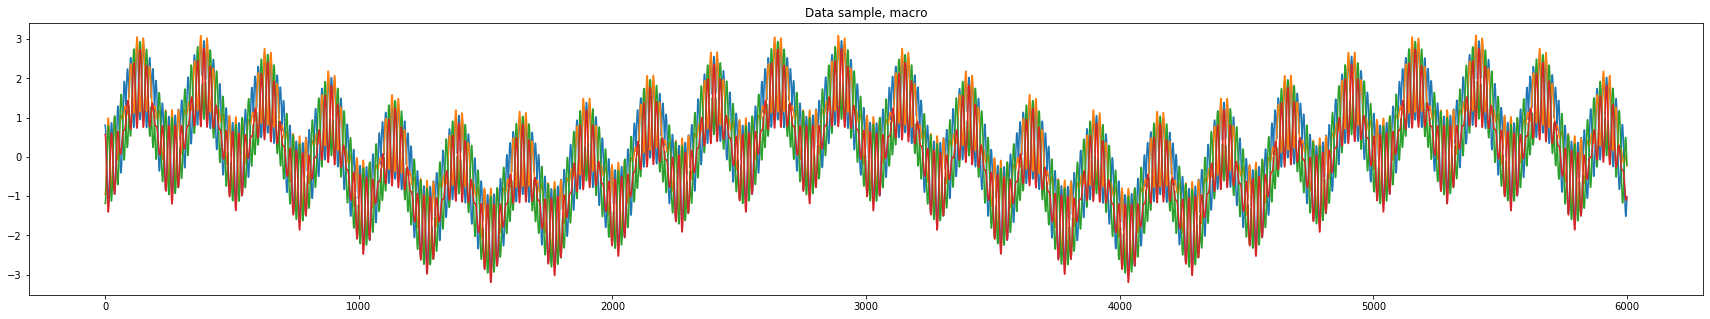

In [3]:
# Data on a macro scale. Structure spans over thousands of rows.

plt.figure(figsize=(30,5))
plt.plot(np.arange(6000), data[:6000,0,:])
plt.title("Data sample, macro")
plt.show()

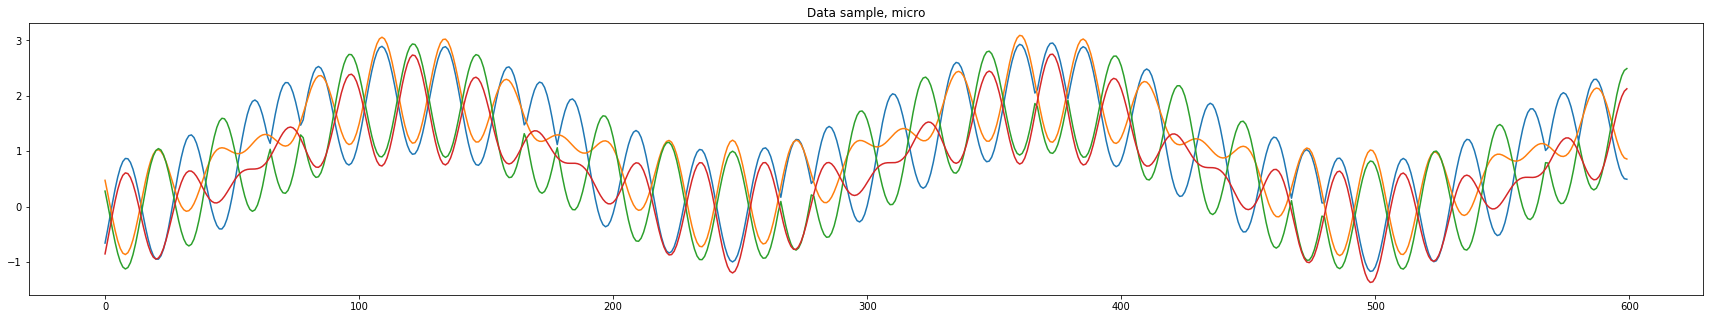

In [4]:
# data on a micro scale, interesting patterns to learn in short-term, as well

sl = 600
ix = np.random.randint(0,len(data)-sl-1)
sample = data[ix:ix+sl, 0, :]
plt.figure(figsize=(30,5))
plt.plot(np.arange(sl), sample)
plt.title("Data sample, micro")
plt.show()

In [5]:
in_sz = data.shape[-1]
n_heads = 3
h_sz = 64 
emb_sz = h_sz * n_heads; # must be even. 
n_blocks = 4
DROP = .1
MAX_MEMORY_STORAGE = 1024
MAX_SEQ_LEN = 180
MAX_BATCH_SZ = bs

emb_sz, h_sz, n_heads, n_blocks

(192, 64, 3, 4)

In [6]:
# We're rolling our own custom functionality for relative position. Same motivation as transformer XL.
# Saving this copy of positional embeddings globally. These will be mixed w key and query to give model awareness of 
# relative position.

def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

r = torch.arange(MAX_MEMORY_STORAGE+MAX_SEQ_LEN, 0, -1).half().unsqueeze(-1).to(device); 
r /= r.max()
p = torch.cat([r,
           r**2,
           r**4, 
           sigmoid(r*10 - 5),
           sigmoid(r*20 - 8),
           sigmoid(r*20 - 12)],
          dim=-1)

p = p.unsqueeze(0).unsqueeze(0)
p = p.expand(MAX_BATCH_SZ, n_heads, p.shape[2], p.shape[3])
p.shape # (bs, n_heads, max len pos emb will ever be asked for, pos emb size)

torch.Size([35, 3, 1204, 6])

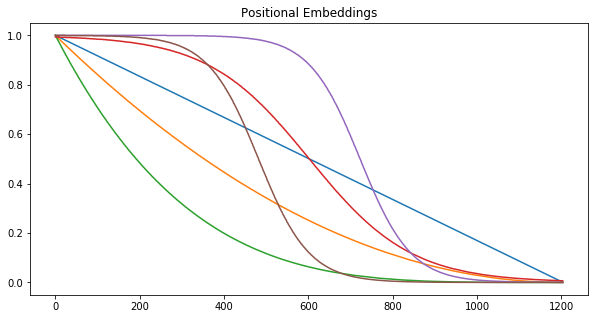

In [7]:
plt.figure(figsize=(10,5))
plt.plot(range(p.shape[2]), p[0,0,:,:].cpu().numpy())
plt.title("Positional Embeddings")
plt.show()

In [8]:
# Attention apparatus. Each module was tested separately before consolidating as below.

def breakout_heads(m):
    """ (bs, seq_len, n_heads*h_sz) => (bs, n_heads, seq_len, h_sz) """ 
    return m.view(m.shape[0], m.shape[1], n_heads, h_sz).transpose(2,1)

class RelativePositioner(nn.Module):
    """ Mix query and key w their relative positions """
    def __init__(self):
        super(RelativePositioner, self).__init__()
        self.fc1 = nn.Linear(h_sz + p.shape[-1], h_sz) # embeddings + positional embeddings. 
        self.fc2 = nn.Linear(h_sz, h_sz)
    
    def forward(self,x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        #x = self.drop(x
        x = self.fc2(x)
        return x
        
class MultiHeadSelfAttention(nn.Module):
    """ 
    Computes multihead self attention as in vanilla transformer. Adds relative positioning like transformer XL 
    though current implementation of relative positioning is custom.
    """
    def __init__(self):
        super(MultiHeadSelfAttention, self).__init__()
        self.kv_linear = nn.Linear(emb_sz, h_sz * n_heads * 2, bias=False)
        self.q_linear = nn.Linear(emb_sz, h_sz * n_heads, bias=False)
        self.resizer = nn.Linear(h_sz*n_heads, emb_sz)
        self.drop = nn.Dropout(DROP)
        self.relative_positioner = RelativePositioner()
        
    def forward(self, x, h):
        # x.shape (bs, seq_len, emb_sz)
        # h.shape (bs, seq_len, emb_sz) h is just like x, but from the previous segment
        b_sz, seq_len, _ = x.shape
        _, prev_seq_len, _ = h.shape
        total_seq_len = seq_len + prev_seq_len
        
        # maybe inject position info followed by proj right here? Investigate further
        kv = self.kv_linear(torch.cat([h,x], dim=1))
        k, v = torch.chunk(kv, 2, dim=-1)
        
        q = self.q_linear(x) 
        
        q, k, v = breakout_heads(q), breakout_heads(k), breakout_heads(v); 
        # Our matrices are now de-consolidated. The above acrobatics were simply to increase performance.
        # q, k and v each now have shape (bs, n_heads, seq_len, h_sz)
    
        # Doing our own custom relative positioning. Found the transformer XL version unsatisfying, don't remember why.
        # TODO research why didn't like transformer XL embeddings, benchmark against our custom version.
        pos = p.clone() #torch.Size([bs, n_heads, max memory + max seqlen, number of positional properties])
        q = torch.cat([q, pos[:b_sz, :, -seq_len:, :]], dim=-1)
        k = torch.cat([k, pos[:b_sz, :, -total_seq_len:, :]], dim=-1)
        q = self.relative_positioner(q)
        k = self.relative_positioner(k)
        
        attention_matrix = torch.einsum('bhsd,bhdz->bhsz', (q, k.transpose(3,2)));
        
        # Scale
        attention_matrix /= h_sz**(1/2)
        
        # mask 
        mask = torch.triu(torch.ones(seq_len, total_seq_len), diagonal=prev_seq_len+1).bool().to(device);
        attention_matrix = attention_matrix.masked_fill(mask, -float('inf'));
        attention_matrix = nn.Softmax(dim=-1)(attention_matrix)
        attention_matrix = self.drop(attention_matrix)
        
        output = torch.matmul(attention_matrix, v)

        output = output.transpose(1,2) # result is (bs, seq_len, n_heads, h_sz)
        output = output.reshape(output.shape[0], output.shape[1], (output.shape[2] * output.shape[3])) # result is (bs, seq_len, n_heads * h_sz), i.e. cat last two dims
        output = self.resizer(output)
        output = self.drop(output)

        return output

In [9]:
# Gated block

class Gate(nn.Module):
    """ GRU gate based on Cho et al 2014 https://arxiv.org/abs/1406.1078 """
    def __init__(self, emb_sz):
        super(Gate, self).__init__()
        W_r = torch.empty(emb_sz + emb_sz, emb_sz)
        W_z = torch.empty(emb_sz + emb_sz, emb_sz)
        W_f = torch.empty(emb_sz + emb_sz, emb_sz)
        
        nn.init.normal_(W_r, std=0.02)
        nn.init.normal_(W_z, std=0.02)
        nn.init.normal_(W_f, std=0.02)
        
        self.W_r = nn.Parameter(W_r)
        self.W_z = nn.Parameter(W_z)
        self.W_f = nn.Parameter(W_f)
        
        z_bias = torch.empty(emb_sz)
        nn.init.constant_(z_bias, 1.)
        self.z_bias = nn.Parameter(z_bias)

    def forward(self, x, h_):
        c = torch.cat([h_, x],dim=-1);
        r = torch.matmul(c, self.W_r)
        r = nn.Sigmoid()(r);
        z = torch.matmul(c, self.W_z); 
        z -= self.z_bias
        z = nn.Sigmoid()(z)
        cf = torch.cat([r * h_, x], dim=-1); 
        hf = nn.Tanh()(torch.matmul(cf, self.W_f)); 
        h = (1. - z)*h_ + z * hf
        return h

class GatedBlock(nn.Module):
    """ Gated block as introduced in GTrXL paper. Allows identity to flow all the way through. """
    def __init__(self):
        super(GatedBlock, self).__init__()
        self.attn = MultiHeadSelfAttention() 
        self.ln_1 = nn.LayerNorm(emb_sz)
        self.ffn = FFN()
        self.ln_2 = nn.LayerNorm(emb_sz)
        self.drop = nn.Dropout(DROP)
        self.gate = Gate(emb_sz)
        self.gate2 = Gate(emb_sz)
        self.relu = nn.ReLU()

    def forward(self, x):
        a = self.attn(self.ln_1(x))
        a = self.drop(a)
        a = self.relu(a)
        g = self.gate(a, x) # residual connection x is equivilent to hidden state, attention output is equivilent to new obs
        
        f = self.ffn(self.ln_2(g))
        f = self.drop(f)
        f = self.relu(f)
        g = self.gate2(f, g)

        return g

In [10]:
# Other choices for block

class ReorderedBlock(nn.Module): # from gated transformer RL
    """ 
    Same components as vanilla transformer block but reordered to allow identity flow through as in GTrXL. 
    Layernorm only happens now on input to attention and ffn modules whereas in vanilla block layernorm happens
    AFTER attn and AFTER ffn, meaning identity can't escape it.
    """
    def __init__(self):
        super(ReorderedBlock, self).__init__()
        self.attn = MultiHeadSelfAttention() 
        self.ln_1 = nn.LayerNorm(emb_sz)
        self.ffn = FFN()
        self.ln_2 = nn.LayerNorm(emb_sz)
        self.drop = nn.Dropout(DROP)

    def forward(self, x, h):
        a = self.attn(self.ln_1(x), self.ln_1(h))
        a = self.drop(a)
        a = nn.ReLU()(a)
        xa = x + a
        f = self.ffn(self.ln_2(xa))
        f = self.drop(f)
        f = nn.ReLU()(f)
        xf = f + xa

        return xf

class Block(nn.Module):
    """ Vanilla transformer block """
    def __init__(self):
        super(Block, self).__init__()
        self.attn = MultiHeadSelfAttention() 
        self.ln_1 = nn.LayerNorm(emb_sz)
        self.ffn = FFN()
        self.ln_2 = nn.LayerNorm(emb_sz)
        self.drop = nn.Dropout(DROP)

    def forward(self, x, h, diff_matrix):
        a = self.attn(x, h, diff_matrix)
        a = self.drop(a)
        n = self.ln_1(x + a)
        m = self.ffn(n)
        m = self.drop(m)
        h = self.ln_2(n + m)

        return h

In [11]:
# Compiling modules into transformer

class FFN(nn.Module):
    """ Simple feedforward network. Two layers separated by activation. Vanilla transformer. """
    def __init__(self): 
        super(FFN, self).__init__()
        hidden_sz = emb_sz * 4
        self.fc1 = nn.Linear(emb_sz, hidden_sz)
        self.fc2 = nn.Linear(hidden_sz, emb_sz)
        
    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
# Currently using reordered block. Couldn't get gated block to work. Either my implementation of GRU is wrong, or my 
# application of the GRU cell into the transformer block was done incorrectly. TODO Reach out to author to try to get more 
# clear description of their gated block.
class Transformer(nn.Module):
    """ 
    Transformer XL with options for using gated blocks, reordered blocks, or vanilla blocks. Uses custom relative 
    positioning like XL, but implemented differently 
    """
    def __init__(self):
        super(Transformer, self).__init__()
        self.input_resizer = nn.Linear(in_sz, emb_sz) 
        #self.blocks = nn.ModuleList([GatedBlock() for _ in range(n_blocks)])
        #self.blocks = nn.ModuleList([Block() for _ in range(n_blocks)])
        self.blocks = nn.ModuleList([ReorderedBlock() for _ in range(n_blocks)])
        self.clf = nn.Linear(emb_sz, in_sz*3) # preds at one and ten and 100
        self.reset_memory(bs)
    
    def reset_memory(self, b):
        # Initialize w a single memory of zeros. depends on batch size, i.e. gen only one at a time
        self.memory = [torch.zeros(b, 1, emb_sz).to(device) for _ in range(n_blocks)]
        
    def add_memory(self, memory_to_add):
        for i, m in enumerate(memory_to_add):
            self.memory[i] = torch.cat([self.memory[i], memory_to_add[i]], dim=1) # cat on seq dim
            self.memory[i] = self.memory[i][:, -MAX_MEMORY_STORAGE:, :] # only store up to a certain amount
        
    def retrieve_memory(self, memory_len):
        return [m[:, -memory_len:, :] for m in self.memory]
    
    def forward(self, x):
        
        memory = self.retrieve_memory(memory_len=540)
        b_sz = x.shape[0]
        k_len = x.shape[1] + memory[0].shape[1]
        q_len = x.shape[1]
        
        x = self.input_resizer(x);
        
        future_memories = []
        for i, block in enumerate(self.blocks):
            future_memories.append(x.detach())
            x = block(x, memory[i])
        clf = self.clf(x); # torch.Size([35, 180, 8])
        clf = torch.chunk(clf, chunks=3, dim=-1)
        
        self.add_memory(future_memories)
        
        return clf

In [12]:
# Prep training and val set
# for val take the last chunk of each of our batches like we'd do for robust time-series validation. This is not a "true"
# validation set in the sense that all data was generated with the exact same formula. Better than nothing though.

val_len = 3000
data_ = torch.FloatTensor(data).to(device)
train = data_[:-val_len]
val = data_[-val_len:] 
train.shape, val.shape

(torch.Size([25571, 35, 4]), torch.Size([3000, 35, 4]))

In [13]:
transformer = Transformer().to(device); 
np.array([p.numel() for p in transformer.parameters()]).sum() # How big is our model? 

1815244

In [14]:
load_saved_model = False
if load_saved_model: transformer.load_state_dict(torch.load("transformer.torch"))

In [15]:
lr = 6e-4
opt = torch.optim.Adam(transformer.parameters(), lr=lr)

In [16]:
# Using Amp for mixed precision training. Awesome that RTX2080 can do mixed precision, increases effective memory significantly
# Simply remove the Amp portions if your GPU doesn't do mixed precision

transformer, opt = amp.initialize(transformer, opt)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [17]:
def do_batch(batch):
    """ 
    Run a single batch of data. Return loss. No backprop. Objective is subsequent-obs prediction, just like language modeling.
    Predicting future obs at three time thresholds. Longer thresholds critical for making model learn macro structure.
    Could also force consistency btwn our different horizon preds. Had trouble making this stable and works fine w/out
    """
    
    batch = batch.permute(1,0,2) # swap batch and seq. batch.shape for this function is (bs, seq_len, x_size)
    horizon_1, horizon_10, horizon_100 = transformer(batch); 
    
    horizon_1 = horizon_1[:, :-1, :];
    horizon_10 = horizon_10[:, :-10, :];
    horizon_100 = horizon_100[:, :-100, :];
    
    loss_1 = ((batch[:, 1:, :] - horizon_1)**2).mean() 
    loss_10 = ((batch[:, 10:, :] - horizon_10)**2).mean() 
    loss_100 = ((batch[:, 100:, :] - horizon_100)**2).mean() 

    return loss_1 + loss_10 + loss_100

# Test a batch
with torch.no_grad():
    loss = do_batch(train[:200, :, :])
    print(loss)

tensor(6.6055, device='cuda:0')


In [18]:
# Transformer's memory store will increase until it reaches max, at which point it'll always drop the oldest. 
# We just initialized model, so memory len should be short

transformer.memory[0].shape

torch.Size([35, 201, 192])

In [19]:
# Vary the seq len to ensure so each epoch never sees the exact same batch, even though same dataset.
min_seq_len = 150
max_seq_len = 180

def do_dataset(data, train=True):
    """ Run through an entire dataset (ie train or val). If train, backprop. Return mean loss for reporting """
    ix = 0; epoch_losses = []; 
    sl = np.random.randint(min_seq_len, max_seq_len)
    while ix < len(data):
        batch = data[ix:ix+sl];
        ix+=sl;
        if batch.shape[0] < 150: continue
        loss = do_batch(batch);
        if train:
            opt.zero_grad(); 
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
            opt.step();
        epoch_losses.append(loss.item());
    return np.array(epoch_losses).mean()

# Test quickly on val set
with torch.no_grad():
    transformer.reset_memory(bs)
    loss = do_dataset(val, train=False); print(loss)

6.4253770510355634


In [ ]:
%%time 
n_epochs = 20; 

for i in range(n_epochs):
    print(i)
    transformer.train(); 
    transformer.reset_memory(bs)
    loss = do_dataset(train, train=True)
    print('epoch train loss', loss)

    with torch.no_grad():
        transformer.eval()
        transformer.reset_memory(bs)
        loss = do_dataset(val, train=False)
        print('epoch val loss', loss.item())
print('done')

0


In [ ]:
torch.save(transformer.state_dict(), "transformer.torch")

## Test model's ability to generate
A model that understood or memorized the sequence should be able to generate the sequence autoregressively with only a small prompt. Investigate these generated sequences to analyze the model's strengths and weaknesses, e.g. simple sine waves are easy to get but macro structure over thousands of steps was more difficult.

In [ ]:
# Take a random chunk from validation set and have transformer generate from it autoregressively. Takes a minute to run
# bc we're generating one at a time.

with torch.no_grad():
    transformer.eval()
    transformer.reset_memory(1)
    
    n_gen = 4000
    ix = np.random.randint(0, val.shape[1]-1)
    seed = val[:180, ix:ix+1, :]
    
    t_out = transformer(seed.permute(1,0,2))
    horizon_1, _, _ = t_out
    next_obs = horizon_1[:, -1:, :].permute(1,0,2) # grab the single next step prediction for last one
        
    for i in range(n_gen):
        t_out = transformer(next_obs)
        horizon_1, _, _ = t_out
        next_obs = horizon_1[:, -1:, :].permute(1,0,2) # grab the single next step prediction for last one
        seed = torch.cat([seed, next_obs.float()],dim=0) # why suddenly need that float()?

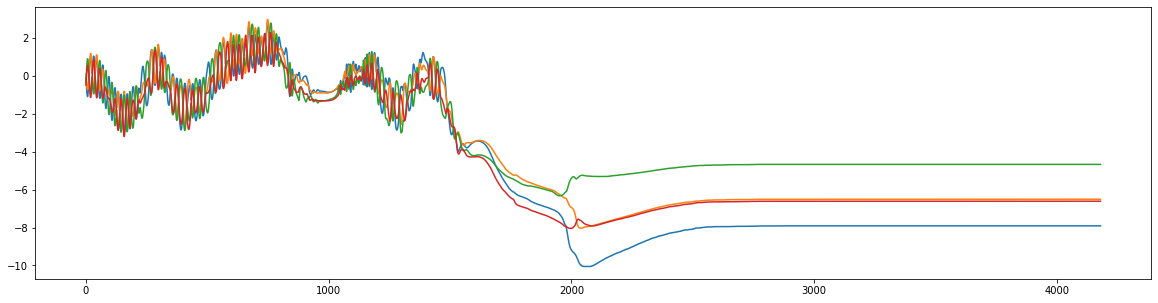

In [23]:
# Entire generated sequence to test macro structure

plt.figure(figsize=(20,5))
plt.plot(np.arange(seed.shape[0]), seed[:, 0, :].detach().cpu().numpy())
plt.show()

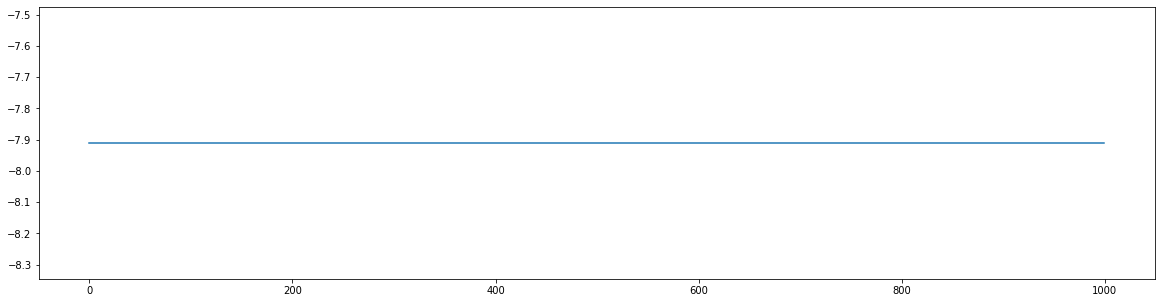

In [24]:
# Close up of one of the waves to test micro structure

plt.figure(figsize=(20,5))
plt.plot(np.arange(1000), seed[-1000:, 0, :1].detach().cpu().numpy())
plt.show()